## Compare VOPy with Optuna on Black-box Vector Optimization
This notebook compares VOPy with the state-of-the-art black-box optimization library called **Optuna**. As a real-world problem, we use a Paal-Knorr reaction for optimization. This problem is implemented in Tu et al, 2022. We will use a variant of PaVeBa (Karagözlü et al, 2023) algorithm for online learning (see [PaVeBaGPOnline](../algorithms.rst#pavebagponline) docs).

- Ben Tu, Axel Gandy, Nikolas Kantas, Behrang Shafei. [Joint Entropy Search for Multi-objective Bayesian Optimization](https://arxiv.org/pdf/2210.02905.pdf). NeurIPS 2022. [GitHub Repo.](https://github.com/benmltu/JES/)

Before starting, make sure the Optuna is installed. We include it as optional-dependencies under `examples`, see `pyproject.toml` in GitHub.

In [1]:
import warnings
from unittest import mock

import logging
from importlib import reload


import matplotlib.pyplot as plt

import torch
import numpy as np
from scipy.stats.qmc import Sobol

import optuna

from vopy.utils import set_seed
from vopy.order import ConeTheta2DOrder
from vopy.algorithms import PaVeBaGPOnline
from vopy.maximization_problem import FixedPointsProblem
from vopy.utils.evaluate import calculate_epsilonF1_score

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

# reload(logging)
# logging.basicConfig(level=logging.INFO)

#### Loading `PK2` from JES dynamically
The code for JES is not properly packaged, so we can not install it using pip. Therefore, we download the file we are interested in and load it manually.

In [2]:
import importlib, sys, pathlib
from urllib.request import urlopen

RAW_URL_COMMIT = "https://raw.githubusercontent.com/benmltu/JES/7ea9856781869c0cd348fb52c7431c40274225e9/jes/benchmarks/chembench.py"
cache_dir = pathlib.Path("tmp/jes/")
cache_dir.mkdir(parents=True, exist_ok=True)

try:
    with urlopen(RAW_URL_COMMIT) as resp:
        source_bytes = resp.read()
except Exception as dl_e:
    raise RuntimeError(f"Failed to download chembench.py from JES repo: {dl_e}")

cached_path = cache_dir / f"chembench.py"
if not cached_path.exists():
    cached_path.write_bytes(source_bytes)

# Load module from cached file
spec_name = f"_jes_chembench"
spec = importlib.util.spec_from_file_location(spec_name, cached_path)

module = importlib.util.module_from_spec(spec)
sys.modules[spec_name] = module

spec.loader.exec_module(module)

PK2 = getattr(module, "PK2")

Fixing a seed for reproducibility.

In [3]:
set_seed(0)

We will create a problem instance for the PK2 problem from JES module. It follows the Botorch API.

In [4]:
noise_var = 0.0001
noise_std = noise_var ** 0.5  # Only known by the problem.

problem = PK2(noise_std=noise_std, negate=True)  # `negate=True` because we are maximizing.

Let's now create our `Order` object to define our preference. Our Pareto set identification and evaluation will be according to this preference.

In [5]:
order = ConeTheta2DOrder(cone_degree=45)

As we will work in a fixed cardinality space, we fix the possible design choices (chemical experiment parameters in this case) beforehand.

In [6]:
design_count = 500

input_bounds = problem._bounds

# Create designs
num_sobol_samples = design_count
sampler = Sobol(problem.dim, scramble=False)
sampler.fast_forward(np.random.randint(low=1, high=max(2, num_sobol_samples)))
X_np = sampler.random(num_sobol_samples)

# Scale designs to the problem bounds
for i, (l, u) in enumerate(input_bounds):
    X_np[:, i] = X_np[:, i] * (u - l) + l

#### Optimizing with different libraries
We'll now setup and run both frameworks (VOPy and Optuna). As algorithms from VOPy has fixed confidence and Optuna has fixed sampling count, we will first run PaVeBaGPOnline from VOPY and then run Optuna using the same number of samples.

#### Set up and run VOPy

In [7]:
paveba_problem = FixedPointsProblem(
    in_points=X_np,
    out_dim=problem.num_objectives,
    objective=lambda x: problem(torch.tensor(x)).numpy(force=True),
)

# Algorithm parameters
epsilon = 0.01
delta = 0.05

paveba_alg = PaVeBaGPOnline(
    epsilon=epsilon,
    delta=delta,
    problem=paveba_problem,
    order=order,
    conf_contraction=128,
    initial_sample_cnt=25,
    reset_on_retrain=False,
)

while True:
    is_done = paveba_alg.run_one_step()

    if is_done:
        break

In [8]:
print(f"PaVeBaGPOnline took {paveba_alg.sample_count} samples (including initial) to finish.")

PaVeBaGPOnline took 128 samples (including initial) to finish.


#### Set up and run Optuna

In [9]:
def optuna_objective(trial):
    tau = trial.suggest_float("tau", problem._bounds[0][0], problem._bounds[0][1])
    temperature = trial.suggest_float("temperature", problem._bounds[1][0], problem._bounds[1][1])
    equivalents = trial.suggest_float("equivalents", problem._bounds[2][0], problem._bounds[2][1])
    suggested_point = np.array([tau, temperature, equivalents])
    
    # We will sample the closest point from the design space.
    distances = np.linalg.norm(X_np - suggested_point, axis=1)
    closest_index = np.argmin(distances)
    inp = torch.tensor(X_np[closest_index]).reshape(1, problem.dim)
    
    return problem(inp).numpy(force=True).tolist()[0]

X = X_np.tolist()
X = [tuple(x) for x in X]

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(optuna_objective, n_trials=paveba_alg.sample_count, timeout=120)
print("Number of trials (equals the sample count of PaVeBaGPOnline): ", len(study.trials))

Number of trials (equals the sample count of PaVeBaGPOnline):  128


### Evaluation

We will evaluate the frameworks. We can start by computing the ground truth values.

In [10]:
Y_true = problem(torch.tensor(X_np), noise=False).numpy(force=True)

We compute the corresponding Pareto set approximations for both frameworks.

In [11]:
optuna_p_set = set()
for trial in study.best_trials:
    trial_pt = np.array((trial.params["tau"], trial.params["temperature"], trial.params["equivalents"]))
    closest_index = np.argmin(np.linalg.norm(trial_pt - X_np, axis=1))
    optuna_p_set.add(closest_index)
optuna_p_set = list(optuna_p_set)

vopy_p_set = list(paveba_alg.P)

Results in cone order that we defined:

In [12]:
dataset = mock.Mock()
dataset.out_data = Y_true
true_pareto_inds = order.get_pareto_set(Y_true)

vopy_epsf1 = calculate_epsilonF1_score(dataset, order, true_pareto_inds, vopy_p_set, epsilon)
optuna_epsf1 = calculate_epsilonF1_score(dataset, order, true_pareto_inds, optuna_p_set, epsilon)

print(f"VOPy epsilon-F1 score: {vopy_epsf1:.2f}")
print(f"Optuna epsilon-F1 score: {optuna_epsf1:.2f}")

VOPy epsilon-F1 score: 0.88
Optuna epsilon-F1 score: 0.27


**As you can see, Optuna can not perform under the vector optimization setting, as they don't encode preferences like VOPy does. While Optuna achieves an $\epsilon$-F1 score of $0.27$, VOPy (using PaVeBaGPOnline algorithm) achieves an $\epsilon$-F1 score of $0.88$, which is significantly better.**

#### Visualization of Pareto sets

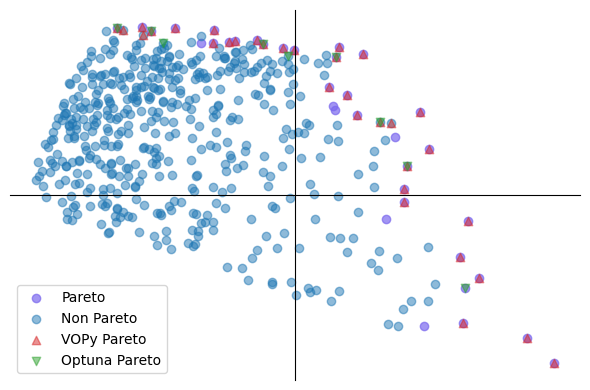

In [13]:
tmp_pareto_fig = order.plot_pareto_set(Y_true)
tmp_pareto_fig.axes[0].scatter(
    dataset.out_data[vopy_p_set][:, 0],
    dataset.out_data[vopy_p_set][:, 1],
    c="tab:red", label="VOPy Pareto", alpha=0.5, marker="^"
)
tmp_pareto_fig.axes[0].scatter(
    dataset.out_data[optuna_p_set][:, 0],
    dataset.out_data[optuna_p_set][:, 1],
    c="tab:green", label="Optuna Pareto", alpha=0.5, marker="v"
)
tmp_pareto_fig.axes[0].legend(loc="lower left")

**We can see that the Pareto set found by vector optimization using VOPy matches highly with the ground truth, whereas the Pareto set found by Optuna is lacking a lot of Pareto optimal points.**